In [67]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=1000)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

# wiki.invoke("What is Machine learning")

In [83]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

from langchain_groq import ChatGroq

llm_groq = ChatGroq(model="qwen-qwq-32b")

In [69]:
from langchain_tavily import TavilySearch

tavily = TavilySearch()

# tavily.invoke("Give me latest Gen AI news")

In [84]:
tools = [arxiv,wiki,tavily]

llm_with_tools = llm_groq.bind_tools(tools=tools)

In [85]:
from langchain_core.messages import AIMessage,HumanMessage

response = llm_with_tools.invoke([HumanMessage(content="What is machine learning")])

response.tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'Machine Learning'},
  'id': '39xtcgkpz',
  'type': 'tool_call'}]

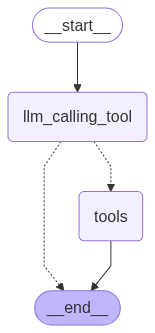

In [44]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


def llm_calling_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("llm_calling_tool",llm_calling_tool)
builder.add_node("tools",ToolNode(tools=tools))

builder.add_edge(START,"llm_calling_tool")
builder.add_conditional_edges(
    "llm_calling_tool",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
) 
builder.add_edge("tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
messages = graph.invoke({"messages":HumanMessage(content="What is attention is all you need")})

messages

{'messages': [HumanMessage(content='What is attention is all you need', additional_kwargs={}, response_metadata={}, id='9ddac149-82bd-44d7-8446-536d1ac279c6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7756m6f8e', 'function': {'arguments': '{"query":"Attention Is All You Need"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1455, 'total_tokens': 1474, 'completion_time': 0.079570836, 'prompt_time': 0.088806014, 'queue_time': 0.053194376, 'total_time': 0.16837685}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a3844a51-63e1-45fe-829f-416543bd191c-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Attention Is All You Need'}, 'id': '7756m6f8e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1455, 'output_tokens': 19, 'total_tokens': 1474}),
  ToolMessage(content="Published: 2024-07-22\nTitle:

In [46]:
from pprint import pprint

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (7756m6f8e)
 Call ID: 7756m6f8e
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention layers only marginally
decreases p

In [58]:
messages = graph.invoke({"messages":HumanMessage(content="Give me AI related news today")})

messages


{'messages': [HumanMessage(content='Give me AI related news today', additional_kwargs={}, response_metadata={}, id='a0244828-5fba-4e6c-a105-40b17bc17d67'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rtwjjv9j0', 'function': {'arguments': '{"query":"AI news today","search_depth":"basic","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1454, 'total_tokens': 1492, 'completion_time': 0.138181818, 'prompt_time': 0.08765424, 'queue_time': 0.052362243, 'total_time': 0.225836058}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--581b019b-9c82-4c26-a91b-f262581e9ed9-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'AI news today', 'search_depth': 'basic', 'time_range': 'day', 'topic': 'news'}, 'id': 'rtwjjv9j0', 'type': 'tool_call'}], usage_metadata={'input_toke

In [59]:
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Give me AI related news today
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rtwjjv9j0)
 Call ID: rtwjjv9j0
  Args:
    query: AI news today
    search_depth: basic
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businesswire.com/news/home/20250625618546/en/Legion-Technologies-Named-AI-based-Workforce-Management-Solution-of-the-Year-in-2025-AI-Breakthrough-Awards-Program", "title": "Legion Technologies Named “AI-based Workforce Management Solution of the Year” in 2025 AI Breakthrough Awards Program - Business Wire", "score": 0.6175132, "published_date": "Wed, 25 Jun 2025 14:00:00 GMT", "content": "Legion Technologies Named “AI-based Workf

In [86]:
messages = graph.invoke({"messages":HumanMessage(content="What is the use of Python in AI")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the use of Python in AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search (pbry1961d)
 Call ID: pbry1961d
  Args:
    query: use of Python in AI
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "use of Python in AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://djangostars.com/blog/why-python-is-good-for-artificial-intelligence-and-machine-learning/", "title": "8 Reasons Why Python is Good for AI and ML - Django Stars", "content": "Frequently Asked Questions\n\nHow Python is used in Artificial Intelligence?\n\nPython is widely used for AI and ML in fintech, travel, transportation, healthcare, and other industries. This programming language is handy for developing AI that helps analyze large

In [88]:
messages = graph.invoke({"messages":HumanMessage(content="How to learn Python for Generative AI")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

How to learn Python for Generative AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search (amv8p7bq5)
 Call ID: amv8p7bq5
  Args:
    query: How to learn Python for Generative AI
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "How to learn Python for Generative AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.dataquest.io/path/generative-ai-fundamentals-skill-track/", "title": "Generative AI Fundamentals in Python - Dataquest", "content": "Start building your expertise using generative AI with this Python programming path, designed for anyone who wants to integrate AI capabilities into their work. You’ll begin with the basics of Python for simple tasks, then learn to interact with LLMs via API